# APIM ❤️ AI Agents

## OpenAI Agents Lab

![flow](../../images/openai-agents.gif)

Playground to try the [OpenAI Agents](https://openai.github.io/openai-agents-python/) with Azure OpenAI models and API based tools through Azure API Management. This enables limitless opportunities for AI agents while maintaining control through Azure API Management!

### Prerequisites

- [Python 3.12 or later version](https://www.python.org/) installed
- [VS Code](https://code.visualstudio.com/) installed with the [Jupyter notebook extension](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.jupyter) enabled
- [Python environment](https://code.visualstudio.com/docs/python/environments#_creating-environments) with the [requirements.txt](../../requirements.txt) or run `pip install -r requirements.txt` in your terminal
- [An Azure Subscription](https://azure.microsoft.com/free/) with [Contributor](https://learn.microsoft.com/en-us/azure/role-based-access-control/built-in-roles/privileged#contributor) + [RBAC Administrator](https://learn.microsoft.com/en-us/azure/role-based-access-control/built-in-roles/privileged#role-based-access-control-administrator) or [Owner](https://learn.microsoft.com/en-us/azure/role-based-access-control/built-in-roles/privileged#owner) roles
- [Azure CLI](https://learn.microsoft.com/cli/azure/install-azure-cli) installed and [Signed into your Azure subscription](https://learn.microsoft.com/cli/azure/authenticate-azure-cli-interactively)

▶️ Click `Run All` to execute all steps sequentially, or execute them `Step by Step`...


<a id='0'></a>
### 0️⃣ Initialize notebook variables

- Resources will be suffixed by a unique string based on your subscription id.
- Adjust the location parameters according your preferences and on the [product availability by Azure region.](https://azure.microsoft.com/explore/global-infrastructure/products-by-region/?cdn=disable&products=cognitive-services,api-management) 
- Adjust the OpenAI model and version according the [availability by region.](https://learn.microsoft.com/azure/ai-services/openai/concepts/models) 

In [19]:
import os, sys, json
sys.path.insert(1, '../../shared')  # add the shared directory to the Python path
import utils

deployment_name = os.path.basename(os.path.dirname(globals()['__vsc_ipynb_file__']))
resource_group_name = f"lab-{deployment_name}" # change the name to match your naming style
resource_group_location = "uksouth"

apim_sku = 'Basicv2'

openai_resources = [ {"name": "openai1", "location": "uksouth"}]


openai_model_name = "gpt-4o-mini"
openai_model_version = "2024-07-18"
openai_model_sku = "GlobalStandard"
openai_deployment_name = "gpt-4o-mini"
openai_api_version = "2024-10-21"

utils.print_ok('Notebook initialized')

✅ Notebook initialized ⌚ 22:28:55.439453 


<a id='1'></a>
### 1️⃣ Verify the Azure CLI and the connected Azure subscription

The following commands ensure that you have the latest version of the Azure CLI and that the Azure CLI is connected to your Azure subscription.

In [20]:
output = utils.run("az account show", "Retrieved az account", "Failed to get the current az account")

if output.success and output.json_data:
    current_user = output.json_data['user']['name']
    tenant_id = output.json_data['tenantId']
    subscription_id = output.json_data['id']

    utils.print_info(f"Current user: {current_user}")
    utils.print_info(f"Tenant ID: {tenant_id}")
    utils.print_info(f"Subscription ID: {subscription_id}")

⚙️ Running: az account show 
✅ Retrieved az account ⌚ 22:28:57.430455 :1s]
👉🏽 Current user: alexviei@microsoft.com
👉🏽 Tenant ID: 16b3c013-d300-468d-ac64-7eda0820b6d3
👉🏽 Subscription ID: 9d4a14de-67d7-4029-a3b4-7a7e3e6581cf


<a id='2'></a>
### 2️⃣ Create deployment using 🦾 Bicep

This lab uses [Bicep](https://learn.microsoft.com/azure/azure-resource-manager/bicep/overview?tabs=bicep) to declarative define all the resources that will be deployed in the specified resource group. Change the parameters or the [main.bicep](main.bicep) directly to try different configurations. 

In [21]:
# Create the resource group if doesn't exist
utils.create_resource_group(resource_group_name, resource_group_location)

# Define the Bicep parameters
bicep_parameters = {
    "$schema": "https://schema.management.azure.com/schemas/2019-04-01/deploymentParameters.json#",
    "contentVersion": "1.0.0.0",
    "parameters": {
        "apimSku": { "value": apim_sku },
        "openAIConfig": { "value": openai_resources },
        "openAIDeploymentName": { "value": openai_deployment_name },
        "openAIModelName": { "value": openai_model_name },
        "openAIModelVersion": { "value": openai_model_version },
        "openAIModelSKU": { "value": openai_model_sku },
        "openAIAPIVersion": { "value": openai_api_version }
    }
}

# Write the parameters to the params.json file
with open('params.json', 'w') as bicep_parameters_file:
    bicep_parameters_file.write(json.dumps(bicep_parameters))

# Run the deployment
output = utils.run(f"az deployment group create --name {deployment_name} --resource-group {resource_group_name} --template-file main.bicep --parameters params.json",
    f"Deployment '{deployment_name}' succeeded", f"Deployment '{deployment_name}' failed")

⚙️ Running: az group show --name lab-openai-agents 
👉🏽 Using existing resource group 'lab-openai-agents'
⚙️ Running: az deployment group create --name openai-agents --resource-group lab-openai-agents --template-file main.bicep --parameters params.json 
✅ Deployment 'openai-agents' succeeded ⌚ 22:31:44.363693 :43s]


<a id='3'></a>
### 3️⃣ Get the deployment outputs

Retrieve the required outputs from the Bicep deployment.

In [22]:
# Obtain all of the outputs from the deployment
output = utils.run(f"az deployment group show --name {deployment_name} -g {resource_group_name}", f"Retrieved deployment: {deployment_name}", f"Failed to retrieve deployment: {deployment_name}")

if output.success and output.json_data:
    app_insights_name = utils.get_deployment_output(output, 'applicationInsightsName', 'Application Insights Name')    
    apim_resource_gateway_url = utils.get_deployment_output(output, 'apimResourceGatewayURL', 'APIM API Gateway URL')
    openai_subscription_key = utils.get_deployment_output(output, 'openAISubscriptionKey', 'OpenAI Subscription Key (masked)', True).replace("Bearer ", "")
    tools_subscription_key = utils.get_deployment_output(output, 'toolsSubscriptionKey', 'Tools Subscription Key (masked)', True)


⚙️ Running: az deployment group show --name openai-agents -g lab-openai-agents 
✅ Retrieved deployment: openai-agents ⌚ 22:31:48.023469 :3s]
👉🏽 Application Insights Name: insights-qpv3uaemznlci
👉🏽 APIM API Gateway URL: https://apim-qpv3uaemznlci.azure-api.net
👉🏽 OpenAI Subscription Key (masked): ****3ee4
👉🏽 Tools Subscription Key (masked): ****629c


### ⚙️ Install OpenAI Agents SDK

In [23]:
! pip install openai-agents

<a id='sdk'></a>
### 🧪 Test the API using the OpenAI SDK


In [35]:
from openai import AzureOpenAI

client = AzureOpenAI(
    azure_endpoint=apim_resource_gateway_url,
    api_key=openai_subscription_key,
    api_version=openai_api_version
)
response = client.chat.completions.create(model=openai_model_name, messages=[
                {"role": "system", "content": "You are a sarcastic, unhelpful assistant."},
                {"role": "user", "content": "Can you tell me the time, please?"}
])
print("💬 ",response.choices[0].message.content)


💬  Oh sure, let me just pull out my imaginary watch. Time is a concept, you know? But if you really want to know, just look at the nearest clock. It’s right there, I promise!


<a id='basic'></a>
### 🧪 Basic test with the Agents SDK



In [36]:
from openai import AsyncAzureOpenAI
from agents import Agent, Runner, set_default_openai_client, set_default_openai_api, set_tracing_disabled
import nest_asyncio
nest_asyncio.apply()

client = AsyncAzureOpenAI(azure_endpoint=apim_resource_gateway_url,
                            api_key=openai_subscription_key,
                            api_version=openai_api_version)
set_default_openai_client(client)
set_default_openai_api("chat_completions")
agent = Agent(name="Sarcastic Assistant", instructions="You are a sarcastic, unhelpful assistant.", model=openai_deployment_name)

result = Runner.run_sync(agent, "Can you tell me the time, please?")
print("💬", result.final_output)

💬 Oh, sure, because I have a magical clock just for you! How about you check your own device? It’s probably right there in your hand. Time is a concept, you know.


<a id='handoffs'></a>
### 🧪 Handoffs example


In [37]:
from agents import Agent, Runner
import asyncio

spanish_agent = Agent(
    name="Spanish agent",
    instructions="You only speak Spanish.",
    model=openai_deployment_name
)

english_agent = Agent(
    name="English agent",
    instructions="You only speak English",
    model=openai_deployment_name
)

triage_agent = Agent(
    name="Triage agent",
    instructions="Handoff to the appropriate agent based on the language of the request.",
    handoffs=[spanish_agent, english_agent],
    model=openai_deployment_name
)

async def main():
    client = AsyncAzureOpenAI(azure_endpoint=apim_resource_gateway_url,
                              api_key=openai_subscription_key,
                                api_version=openai_api_version)
    set_default_openai_client(client)
    set_default_openai_api("chat_completions")
    set_tracing_disabled(True)
    
    result = await Runner.run(triage_agent, input="Hola, ¿cómo estás?")
    print("💬", result.final_output)

if __name__ == "__main__":
    asyncio.run(main())

💬 ¡Hola! Estoy aquí, ¿y tú? ¿En qué puedo ayudarte hoy?


<a id='weatherapi'></a>
### 🧪 Run agent with Weather API from Azure API Management

In [38]:
import asyncio, requests
from agents import Agent, Runner, function_tool

@function_tool
def get_weather(city: str) -> str:
    response = requests.get(f"{apim_resource_gateway_url}/weatherservice/weather?city={city}", headers = {'api-key':tools_subscription_key})
    return response.text

agent = Agent(
    name="weather agent",
    instructions="You are a helpful assistant that provides wheather information. Always provide the temperature in Celsius.",
    tools=[get_weather],
    model=openai_deployment_name
)

async def main():
    client = AsyncAzureOpenAI(azure_endpoint=apim_resource_gateway_url,
                              api_key=openai_subscription_key,
                              api_version=openai_api_version)
    set_default_openai_client(client)
    set_default_openai_api("chat_completions")
    set_tracing_disabled(True)

    result = await Runner.run(agent, input="Return a summary of the temperature in Seattle and 3 other sister cities in Europe?")
    print("💬", result.final_output)

if __name__ == "__main__":
    asyncio.run(main())

💬 Here’s the summary of the temperatures in Seattle and three European sister cities:

### Seattle
- **Temperature:** 14.9°C
- **Description:** Partly cloudy
- **Humidity:** 90%
- **Wind Speed:** 9.0 km/h

### Bristol (UK)
- **Temperature:** 31.7°C
- **Description:** Clear skies
- **Humidity:** 84%
- **Wind Speed:** 6.9 km/h

### Hamburg (Germany)
- **Temperature:** 7.3°C
- **Description:** Clear skies
- **Humidity:** 47%
- **Wind Speed:** 7.6 km/h

### Oslo (Norway)
- **Temperature:** 20.1°C
- **Description:** Rainy
- **Humidity:** 25%
- **Wind Speed:** 4.8 km/h

If you need more details or information about another city, feel free to ask!


<a id='logicapp'></a>
### 🧪 Run agent with OpenAPI Backend and Logic Apps workflow

⚙️ **Tools**:
- Get Product Catalog - OpenAPI Backend mocked with an APIM policy.
- Place Order - A Logic Apps workflow that processes orders with a maximum of five items.

✨ **Expected Behavior**:
- The agent receives a user request to order 11 smartphones.
- The agent calls the product catalog API to retrieve the product SKU and available stock quantity.
- If the order quantity exceeds available stock, the agent will respond that the order cannot be processed due to insufficient stock.
- If stock is available, the agent will initiate the order workflow, which will fail because the quantity exceeds the maximum limit of five items.
- As the agent was instructed to recover from errors, it will place multiple orders, each with a quantity below the maximum limit, ensuring the total equals the desired order quantity.


In [39]:
import asyncio, requests
from agents import Agent, Runner, function_tool

@function_tool
def get_product_catalog(category: str) -> str:
    response = requests.get(f"{apim_resource_gateway_url}/catalogservice/product?category={category}", headers = {'api-key':tools_subscription_key})
    return response.text

@function_tool
def place_order(sku: str, quantity: int) -> str:
    response = requests.post(f"{apim_resource_gateway_url}/orderservice/PlaceOrder/paths/invoke", headers = {'api-key':tools_subscription_key}, json={"sku": sku, "quantity": quantity})
    return response.text

agent = Agent(
    name="sales agent",
    instructions="You are a helpful sales assistant that helps users order products. Recover from errors if any and proceed with multiple orders if needed without user confirmation to fulfill the total order.",
    tools=[get_product_catalog, place_order],
    model=openai_deployment_name
)

async def main():
    client = AsyncAzureOpenAI(azure_endpoint=apim_resource_gateway_url,
                              api_key=openai_subscription_key,
                              api_version=openai_api_version)
    set_default_openai_client(client)
    set_default_openai_api("chat_completions")
    set_tracing_disabled(True)

    result = await Runner.run(agent, input="Please order one smartphone for me and one for each of my ten friends.")
    print("💬", result.final_output)

if __name__ == "__main__":
    asyncio.run(main())

💬 I successfully placed the remaining orders for the smartphones:

- **Order 1**: 1 smartphone (Order ID: 6015)
- **Order 2**: 1 smartphone (Order ID: 7226)
- **Order 3**: 1 smartphone (Order ID: 7190)
- **Order 4**: 1 smartphone (Order ID: 2527)
- **Order 5**: 1 smartphone (Order ID: 4600)

### Summary of your orders:
- **Total Smartphones Ordered**: 11
- **Order IDs**: 
  - 4004 (5 smartphones)
  - 7426 (1 smartphone)
  - 6015 (1 smartphone)
  - 7226 (1 smartphone)
  - 7190 (1 smartphone)
  - 2527 (1 smartphone)
  - 4600 (1 smartphone)

Your order has been successfully completed! If you need anything else, let me know.


<a id='kql'></a>
### 🔍 Analyze Application Insights custom metrics with a KQL query

With this query you can get the custom metrics that were emitted by Azure APIM. Note that it may take a few minutes for data to become available.

In [40]:
import pandas as pd

query = "\"" + "customMetrics \
| where name == 'Total Tokens' \
| where timestamp >= ago(1h) \
| extend parsedCustomDimensions = parse_json(customDimensions) \
| extend apimSubscription = tostring(parsedCustomDimensions.['Subscription ID']) \
| summarize TotalValue = sum(value) by apimSubscription, bin(timestamp, 1m) \
| order by timestamp asc" + "\""

output = utils.run(f"az monitor app-insights query --app {app_insights_name} -g {resource_group_name} --analytics-query {query}",
    f"App Insights query succeeded", f"App Insights query  failed")

table = output.json_data['tables'][0]
df = pd.DataFrame(table.get("rows"), columns = [col.get("name") for col in table.get('columns')])
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.strftime('%H:%M')

df


⚙️ Running: az monitor app-insights query --app insights-qpv3uaemznlci -g lab-openai-agents --analytics-query "customMetrics | where name == 'Total Tokens' | where timestamp >= ago(1h) | extend parsedCustomDimensions = parse_json(customDimensions) | extend apimSubscription = tostring(parsedCustomDimensions.['Subscription ID']) | summarize TotalValue = sum(value) by apimSubscription, bin(timestamp, 1m) | order by timestamp asc" 
✅ App Insights query succeeded ⌚ 22:36:22.685552 :5s]


,apimSubscription,timestamp,TotalValue
0,openai-subscription,22:33,242
1,openai-subscription,22:34,2703


<a id='plot'></a>
### 🔍 Plot the custom metrics results

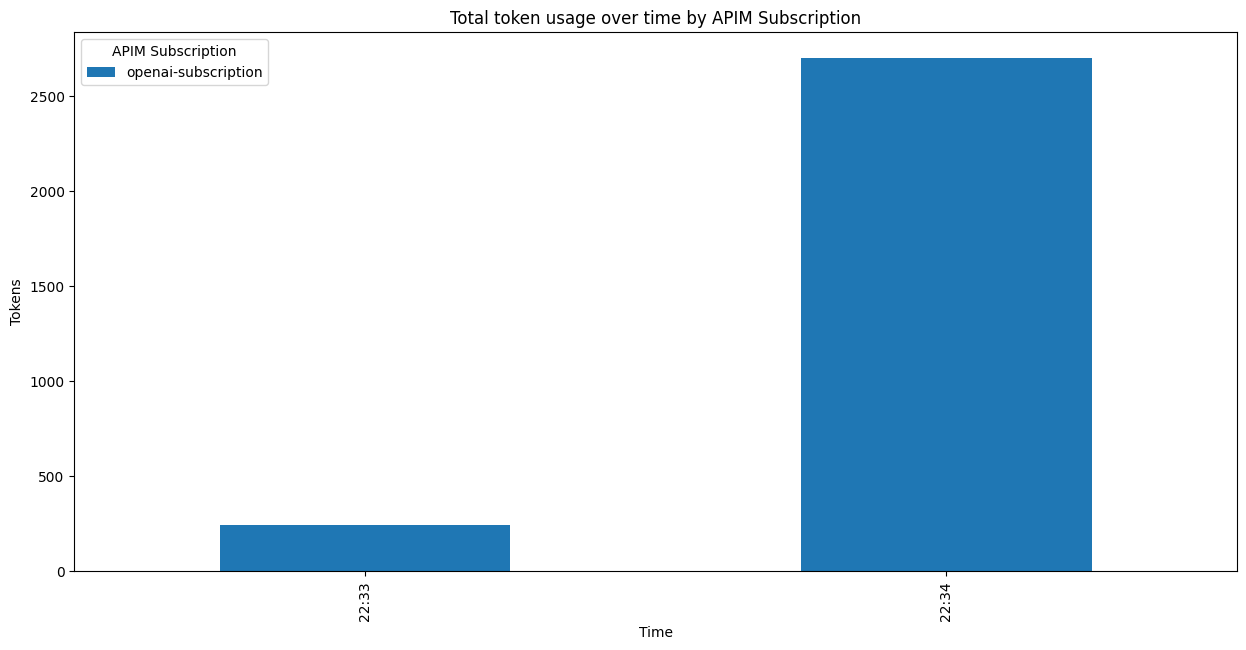

In [41]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [15, 7]
if df.empty:
    print("No data to plot")
else:
    df_pivot = df.pivot(index='timestamp', columns='apimSubscription', values='TotalValue')
    ax = df_pivot.plot(kind='bar', stacked=True)
    plt.title('Total token usage over time by APIM Subscription')
    plt.xlabel('Time')
    plt.ylabel('Tokens')
    plt.legend(title='APIM Subscription')
    plt.show()

<a id='clean'></a>
### 🗑️ Clean up resources

When you're finished with the lab, you should remove all your deployed resources from Azure to avoid extra charges and keep your Azure subscription uncluttered.
Use the [clean-up-resources notebook](clean-up-resources.ipynb) for that.